# **Problem**
We will use XGBoost Classifier to predict future prices movement of the security by creating a custom list of features from the raw price series.

In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data visualization
from pylab import mpl, plt
plt.rcParams['figure.figsize'] = (20, 10)

# Preprocessing
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# XGBoostClassifier
from xgboost import XGBClassifier, plot_importance

# Metrics
from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score, auc)
from sklearn.metrics import(confusion_matrix, classification_report)
from sklearn.metrics import (precision_recall_curve, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay)

# **Load The Data**

We will retrieve the adjusted closed price of SPY from locally stored data.

In [ ]:
df= pd.read_csv('/content/spy.csv', index_col = 0, parse_dates = True)[['Adj Close']]

# Calculate returns
df['Ret'] = np.log(df['Adj Close']).diff()
df.tail()

,Adj Close,Ret,Ret_1M
Date,,,
2020-04-23,279.079987,-0.000072,0.122961
2020-04-24,282.970001,0.013842,0.080054
2020-04-27,287.049988,0.014315,0.124608
2020-04-28,285.730011,-0.004609,0.088040
2020-04-29,293.209991,0.025842,0.128899


# **EDA of Dataset**

In [ ]:
df.describe()

,Adj Close,Ret,Ret_1M
count,5114.000000,5113.000000,5094.000000
mean,136.333938,0.000210,0.004050
std,67.923663,0.012557,0.048516
min,54.184429,-0.115887,-0.370872
25%,87.412493,-0.004649,-0.016835
50%,106.488850,0.000642,0.011823
75%,182.951584,0.005801,0.031307
max,336.362091,0.135577,0.212052


# **Cleaning & Imputation**

Data is already cleaned. However, NaN values from derived features should be treated.

In [ ]:
df.isnull().sum()

,0
Adj Close,0
Ret,1
Ret_1M,20


# **Feature Specification**

In [ ]:
# Create feature lists
features_list = []
for i in range(10, 65, 5):
  df['Ret' + str(i)] = df['Ret'].rolling(i).sum()
  df['Std' + str(i)] = df['Ret'].rolling(i).std()
  features_list.append('Ret' + str(i))
  features_list.append('Std' + str(i))

# Drop NaN values
df.dropna(inplace = True)

# **Label Definition**

The target variable is whether the Nifty Index price will close up or down on the next trading day. If tomorrow's closing price is greater than 99.5% of today's closing price, then we will buy the Nifty; otherwise, we will sell the index.

We assign a value of \( +1 \) for the buy signal and \( -1 \) for the sell signal to the target variable. The target variable can be defined as:  
  
$
y_{t} =
\begin{cases}
    +1, & \text{if } p_{t+1} > 0.995 \times p_{t}, \\
    -1, & \text{otherwise}.
\end{cases}
$

where, $p_{t}$ is the closing price of Nifty index and $p_{t+1}$ is the 1-day forward closing price of index.


In [ ]:
# Define target
df['Target'] = np.where(df['Adj Close'].shift(-1) > 0.995 * df['Adj Close'], 1, 0)

df

,Adj Close,Ret,Ret_1M,Ret10,Std10,Ret15,Std15,Ret20,Std20,Ret25,...,Std40,Ret45,Std45,Ret50,Std50,Ret55,Std55,Ret60,Std60,Target
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-28,103.501099,-0.005776,0.097063,0.102992,0.016808,0.099909,0.017161,0.097063,0.016531,0.115189,...,0.015079,0.076137,0.015692,0.030012,0.015742,0.038339,0.015368,0.030650,0.017420,1
2000-03-29,103.608170,0.001034,0.090847,0.080964,0.016388,0.102198,0.017096,0.090847,0.016542,0.104483,...,0.015027,0.065879,0.015623,0.038945,0.015694,0.035949,0.015363,0.041519,0.017367,0
2000-03-30,101.873848,-0.016881,0.073289,0.018427,0.011734,0.056512,0.016967,0.073289,0.017210,0.107945,...,0.015315,0.056956,0.015801,0.013952,0.015853,0.031106,0.015451,0.064530,0.016697,1
2000-03-31,103.030037,0.011285,0.066024,0.023125,0.012035,0.073135,0.016873,0.066024,0.016954,0.122857,...,0.015243,0.072244,0.015850,0.040662,0.015763,0.052389,0.015448,0.074028,0.016749,1
2000-04-03,103.629585,0.005802,0.081618,0.034044,0.011779,0.089925,0.016292,0.081618,0.016677,0.107899,...,0.015233,0.109737,0.015023,0.048626,0.015772,0.044739,0.015368,0.096032,0.016601,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-23,279.079987,-0.000072,0.122961,0.018261,0.021258,0.125557,0.025494,0.122961,0.029821,0.156723,...,0.046138,-0.186690,0.043884,-0.177545,0.041639,-0.158879,0.039758,-0.152262,0.038192,1
2020-04-24,282.970001,0.013842,0.080054,0.017001,0.021175,0.116587,0.025235,0.080054,0.027437,0.168442,...,0.045663,-0.168731,0.043966,-0.170125,0.041688,-0.156518,0.039775,-0.137593,0.038250,1
2020-04-27,287.049988,0.014315,0.124608,0.040488,0.021137,0.145462,0.024500,0.124608,0.026296,0.226808,...,0.045725,-0.144063,0.044036,-0.154741,0.041763,-0.145562,0.039834,-0.126518,0.038304,1


In [ ]:
# Features
X = df.drop(['Adj Close', 'Ret', 'Ret_1M', 'Target'], axis = 1)
X.values

array([[ 0.10299217,  0.01680829,  0.09990879, ...,  0.01536765,
         0.03065013,  0.01742033],
       [ 0.08096385,  0.01638798,  0.10219782, ...,  0.01536317,
         0.04151947,  0.01736735],
       [ 0.01842677,  0.01173377,  0.05651238, ...,  0.01545088,
         0.06453017,  0.01669711],
       ...,
       [ 0.04048814,  0.02113725,  0.14546178, ...,  0.03983401,
        -0.12651806,  0.03830417],
       [ 0.00681279,  0.01931243,  0.07584602, ...,  0.03983321,
        -0.11280233,  0.03824664],
       [ 0.05413158,  0.01907551,  0.10066876, ...,  0.03999635,
        -0.09436169,  0.03839629]])

In [ ]:
# Labels
y = df['Target']
y

,Target
Date,
2000-03-28,1
2000-03-29,0
2000-03-30,1
2000-03-31,1
2000-04-03,0
...,...
2020-04-23,1
2020-04-24,1
2020-04-27,1


# **Split Data**

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = False)

# Train and test size
print(f'The size of train & test set is: {len(X_train)}, {len(X_test)}')

The size of train & test set is: 4043, 1011


# **Base Model**

We will now create and train the XGBoost (Regessor).

In [ ]:
# Scale and fit the classifier model
model = XGBClassifier(verbosity = 0, silent = True, random_state = 42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# **Predict Model**

In [ ]:
# Predict the test set
y_pred = model.predict(X_test)

In [ ]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_pred, y_test)

print(f'Train Accuracy: {acc_train}', f'Test Accuracy: {acc_test}')

Train Accuracy: 0.9948058372495672 Test Accuracy: 0.7378832838773491


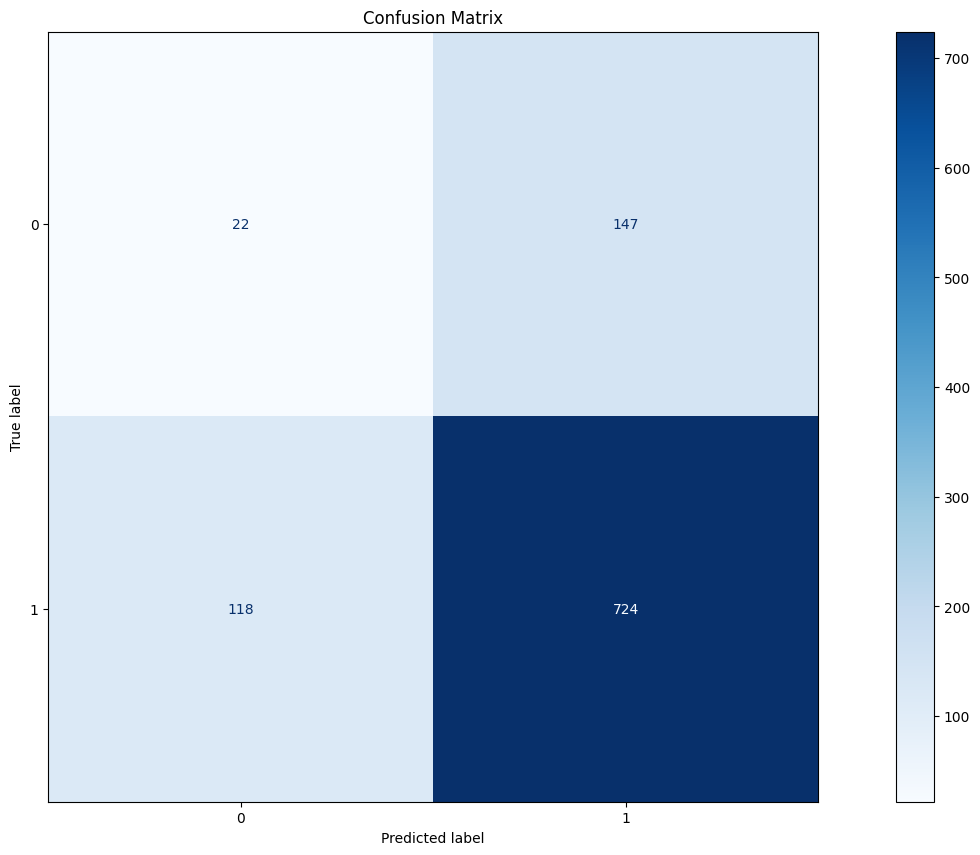

In [ ]:
# Display Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels = model.classes_,
    cmap = plt.cm.Blues
)

disp.ax_.set_title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.16      0.13      0.14       169
           1       0.83      0.86      0.85       842

    accuracy                           0.74      1011
   macro avg       0.49      0.50      0.49      1011
weighted avg       0.72      0.74      0.73      1011



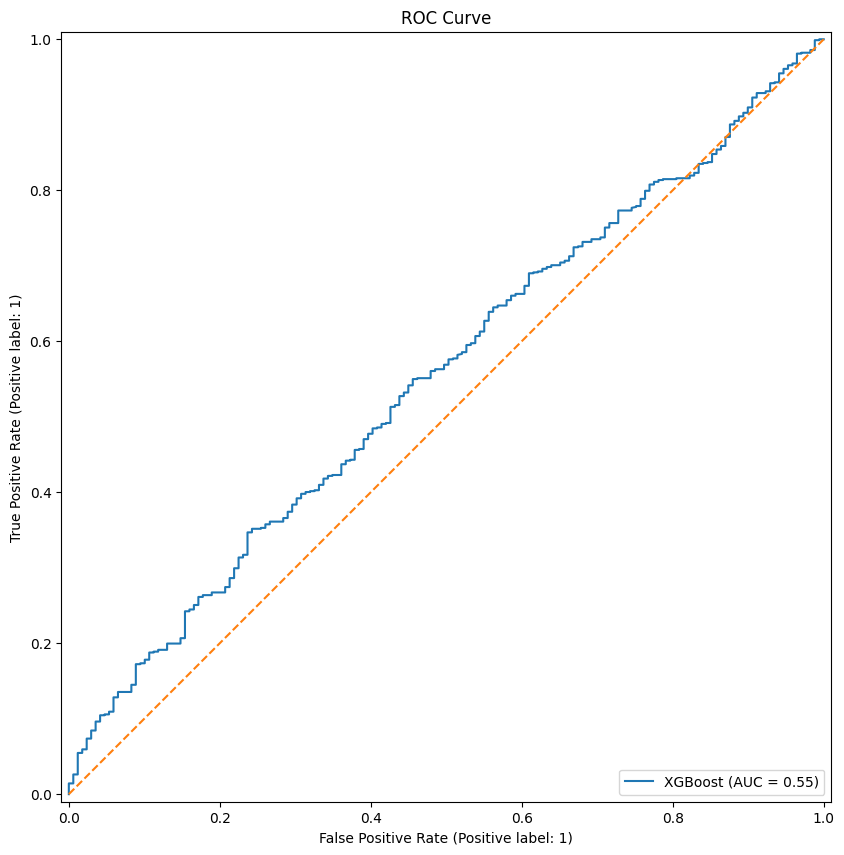

In [ ]:
# Roc Curve Display
roc_curve = RocCurveDisplay.from_estimator(
    model,
    X_test,
    y_test,
    name = 'XGBoost'
)

roc_curve.ax_.set_title('ROC Curve')
plt.plot([0, 1], [0, 1], ls = '--')
plt.show()

# **Hyperparameters Tuning**

Hyper-parameters are parameters that are not directly learnt within estimators. They are passed as arguments to the constructor of the estimator classes (Classifier in this case). It is possible and recommended to search the hyper-parameter space for the best cross validation score. Any parameter provided when constructing an estimator may be optimized in this manner.

We will tune the hyperparameters to select the best score by TimeSeriesSplit cross-validation. This is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set. Unlike standard cross-validation methods, successive training sets are supersets of those that come before them.

**XGBoost's hyper-parameters**  
  
XGBoost has plethora of tuning parameters includeing the regulatization parameters and some of the most common hyperparameters are:


*   learning rate: step size shrinkage used in update to prevents overfitting.
Range is [0,1].
  
*   max_depth: maximum depth of a tree.  
  
*   colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
*   min_child_weight: minimum sum of instance weight needed in a child.
*   gamma: minimum loss reduction required to make a further partition on a leaf node of the tree. Large gamma will lead to more conservative algorithm.
*   lambda: L2 regularization term on weights. Increasing this value will make model more conservative. Normalised to number of training examples. [parameter for linear booster].



**Randomized Search**

The RandomizedSearchCV implements a “fit” and a “score” method and perform randomized search on hyper parameters. The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings. In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions.

In [ ]:
# Cross - validation
tscv = TimeSeriesSplit(n_splits = 5, gap = 1)

In [ ]:
# Get params list
model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 0,
 'silent': True}

In [ ]:
# Hyperparameters Optimization
params_grid = {
  'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
  'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
  'min_child_weight': [1, 3, 5, 7],
  'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
  'colsample_bytree': [0.3, 0.4, 0.5 , 0.7]
}

# Randomized Search
rs = RandomizedSearchCV(model, params_grid, cv = tscv, n_jobs = -1, scoring = 'f1', verbose = 0, n_iter = 100)
rs.fit(X_train, y_train, verbose = 0)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=N...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='f1', verbose=10)

In [ ]:
# Best params
rs.best_params_

{'min_child_weight': 5,
 'max_depth': 3,
 'learning_rate': 0.05,
 'gamma': 0.0,
 'colsample_bytree': 0.3}

In [ ]:
rs.best_score_

0.8359118039599978

# **Tuned Model**

In [ ]:
# Refit the XGBClassifier with the best params
xgb_clf = XGBClassifier(**rs.best_params_, eval_metric='logloss')
xgb_clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)

[0]	validation_0-logloss:0.56790	validation_1-logloss:0.48021
[1]	validation_0-logloss:0.56604	validation_1-logloss:0.47823
[2]	validation_0-logloss:0.56443	validation_1-logloss:0.47586
[3]	validation_0-logloss:0.56289	validation_1-logloss:0.47335
[4]	validation_0-logloss:0.56143	validation_1-logloss:0.47104
[5]	validation_0-logloss:0.56000	validation_1-logloss:0.46987
[6]	validation_0-logloss:0.55880	validation_1-logloss:0.46779
[7]	validation_0-logloss:0.55748	validation_1-logloss:0.46600
[8]	validation_0-logloss:0.55629	validation_1-logloss:0.46434
[9]	validation_0-logloss:0.55516	validation_1-logloss:0.46302
[10]	validation_0-logloss:0.55415	validation_1-logloss:0.46122
[11]	validation_0-logloss:0.55323	validation_1-logloss:0.45988
[12]	validation_0-logloss:0.55225	validation_1-logloss:0.45870
[13]	validation_0-logloss:0.55142	validation_1-logloss:0.45738
[14]	validation_0-logloss:0.55071	validation_1-logloss:0.45618
[15]	validation_0-logloss:0.54985	validation_1-logloss:0.45509
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Return evaluation results
evals_result = xgb_clf.evals_result()
evals_result

{'validation_0': OrderedDict([('logloss',
               [0.5678993838053955,
                0.5660409042217812,
                0.5644349281722415,
                0.5628868624284189,
                0.5614347340902597,
                0.5600015689263449,
                0.5588028602027492,
                0.5574834482035306,
                0.5562866811568921,
                0.555158975931963,
                0.5541536373547212,
                0.5532265108667503,
                0.5522501145793812,
                0.5514160073573066,
                0.5507098939486315,
                0.5498527364214252,
                0.5491475947873886,
                0.5483658500430374,
                0.5477609118553132,
                0.5470818970909869,
                0.5463308214905414,
                0.5457584915768826,
                0.5452000765982695,
                0.5447142695454775,
                0.5442633870035417,
                0.5437265791767397,
                0.54314

In [ ]:
# Cross - validation score
cross_val = cross_val_score(xgb_clf, X_train, y_train, cv = tscv)
print(f'Mean CV score: {cross_val.mean()}')

Mean CV score: 0.7274888558692421


# **Feature Importance**

Feature Importance refers to techniques that calculate a score for all the input features for a given model where the scores represent the “importance” of each feature. It is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.

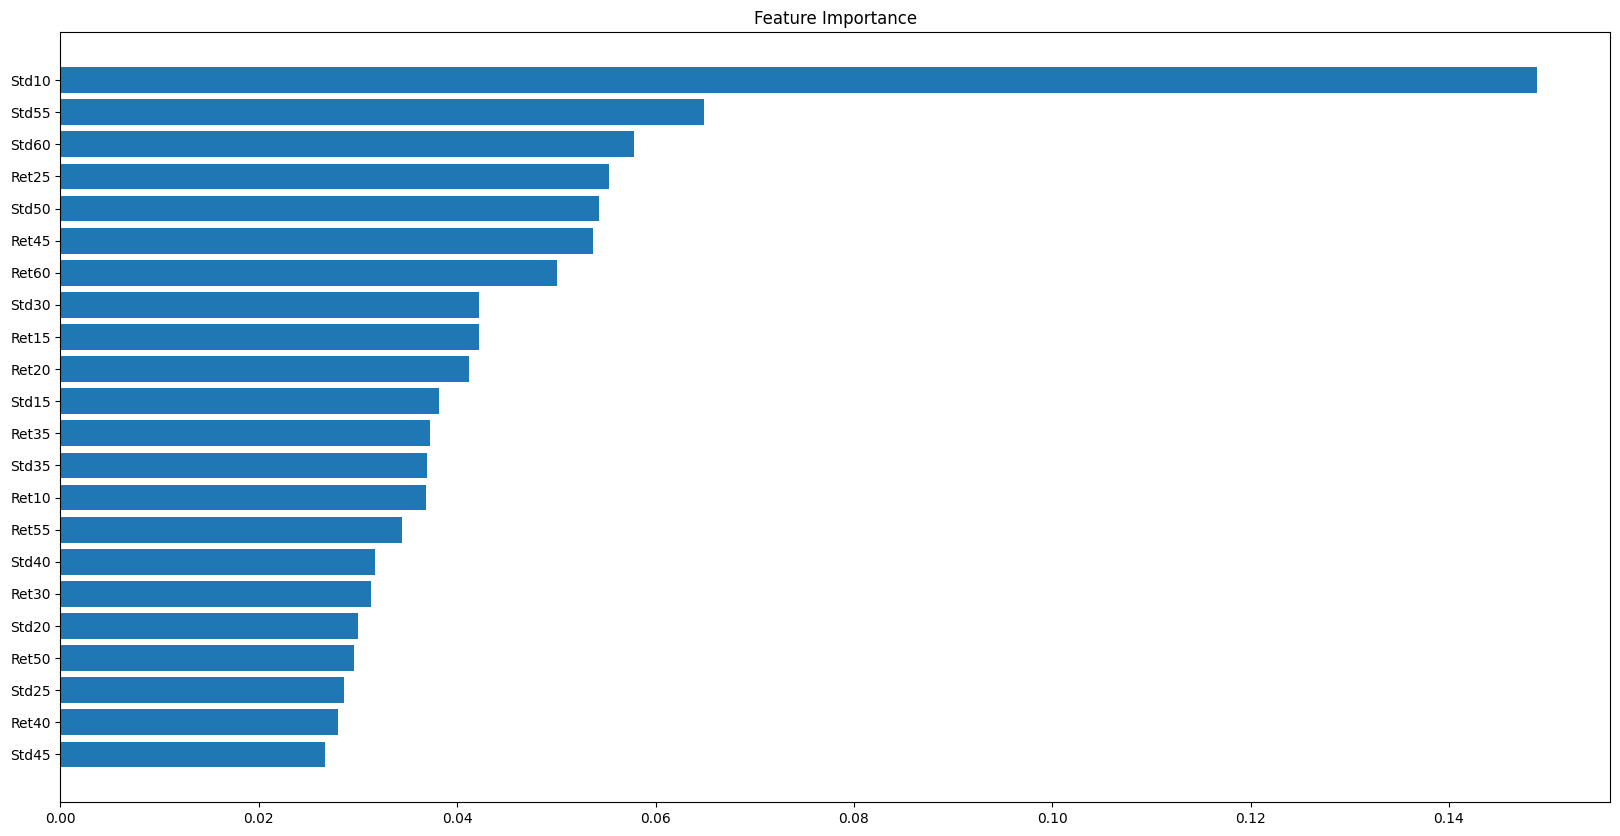

In [ ]:
# Plot feature important
feature_imp = pd.DataFrame({'Importance Score' : xgb_clf.feature_importances_, 'Features' : X.columns}).sort_values(by = 'Importance Score', ascending = True)
plt.barh(feature_imp['Features'], feature_imp['Importance Score'])
plt.title('Feature Importance')
plt.show()

Importance type can be either of the following:

*   weight: the number of times a feature is used to split the data across all trees.  
  
*   gain: the average gain across all splits the feature is used in.
*   cover: the average coverage across all splits the feature is used in.
*   total_gain: the total gain across all splits the feature is used in.
*   total_cover: the total coverage across all splits the feature is used in.





<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

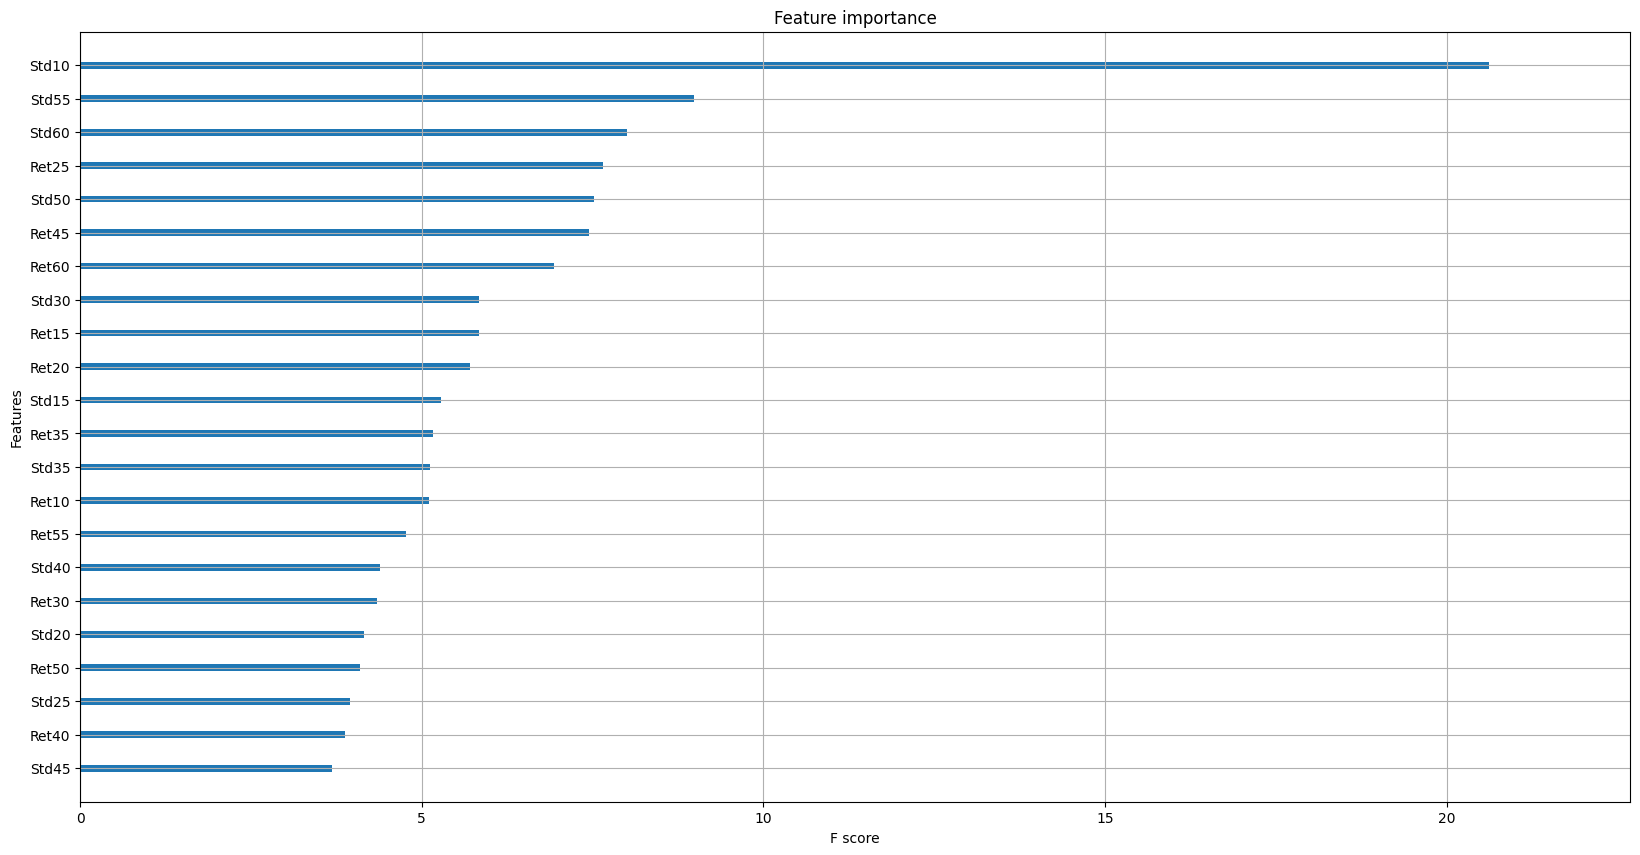

In [ ]:
# Plot feature importance with importance_type = 'gain'
plot_importance(xgb_clf, importance_type = 'gain', show_values = False)

# **SHAP values**

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. Shapley values are a widely used approach from cooperative game theory that come with desirable properties and is the average marginal contribution of a feature value across all possible coalitions.

In [ ]:
import shap
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

**Visualize the feature importance**

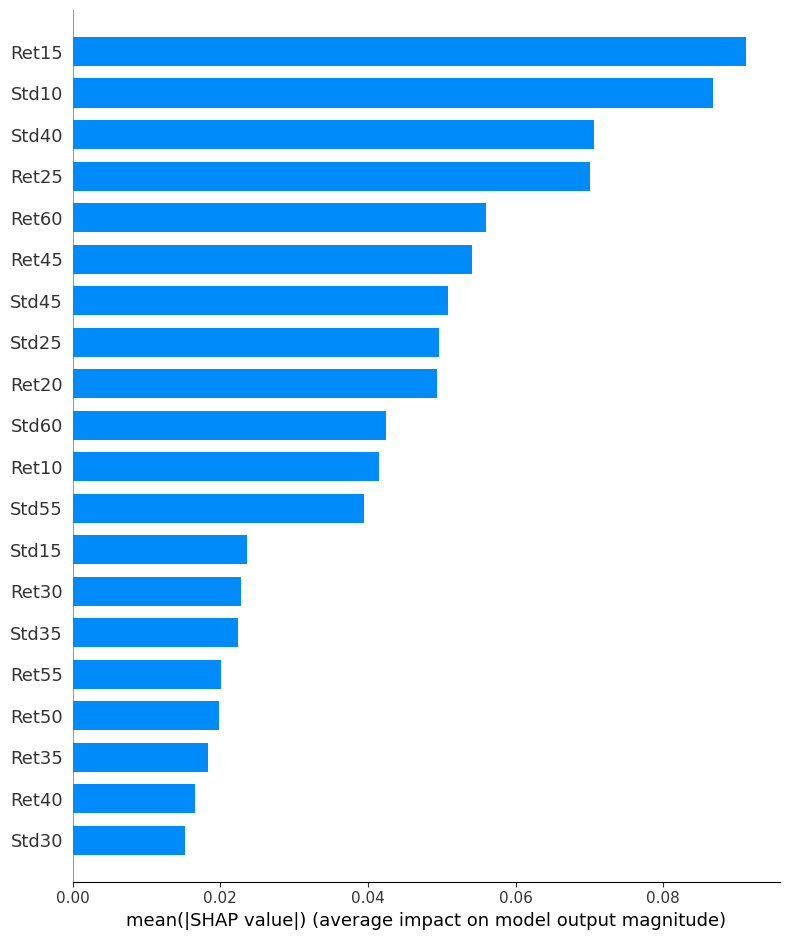

In [ ]:
# Feature importance summary
shap.summary_plot(shap_values, X_test, plot_type = 'bar')

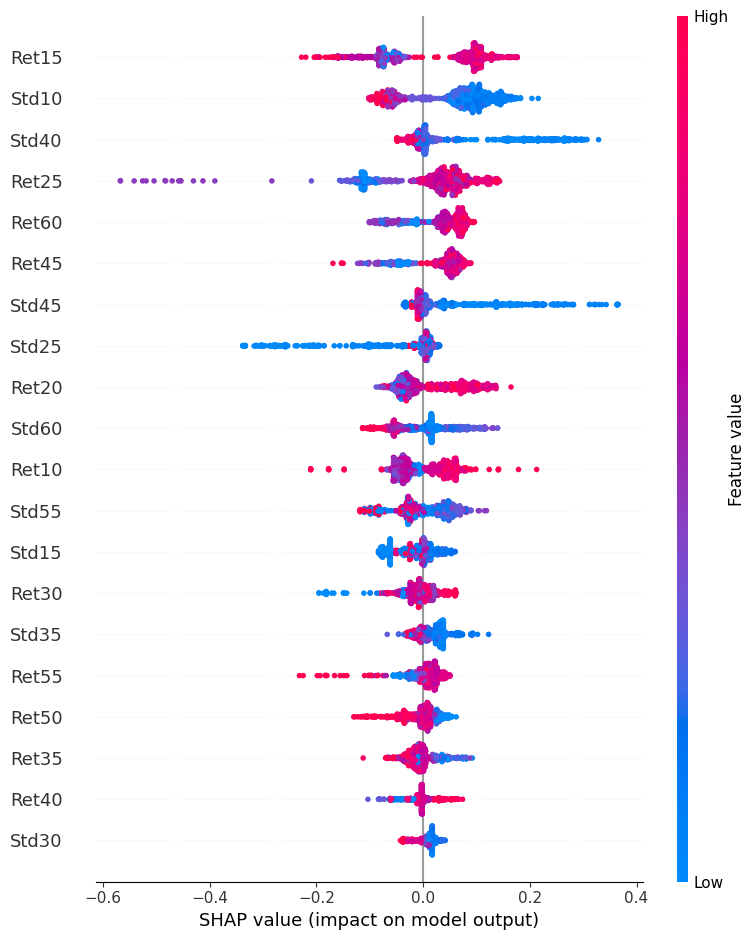

In [ ]:
# Interpretation plot
shap.summary_plot(shap_values, X_test)

# **Predict Model**

In [ ]:
# Predict test set
y_pred = xgb_clf.predict(X_test)

# Measure Accuracy
acc_train = accuracy_score(y_train, xgb_clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train} \n Test Accuracy \t\t: {acc_test}')


 Training Accuracy 	: 0.7482067771456838 
 Test Accuracy 		: 0.8318496538081108


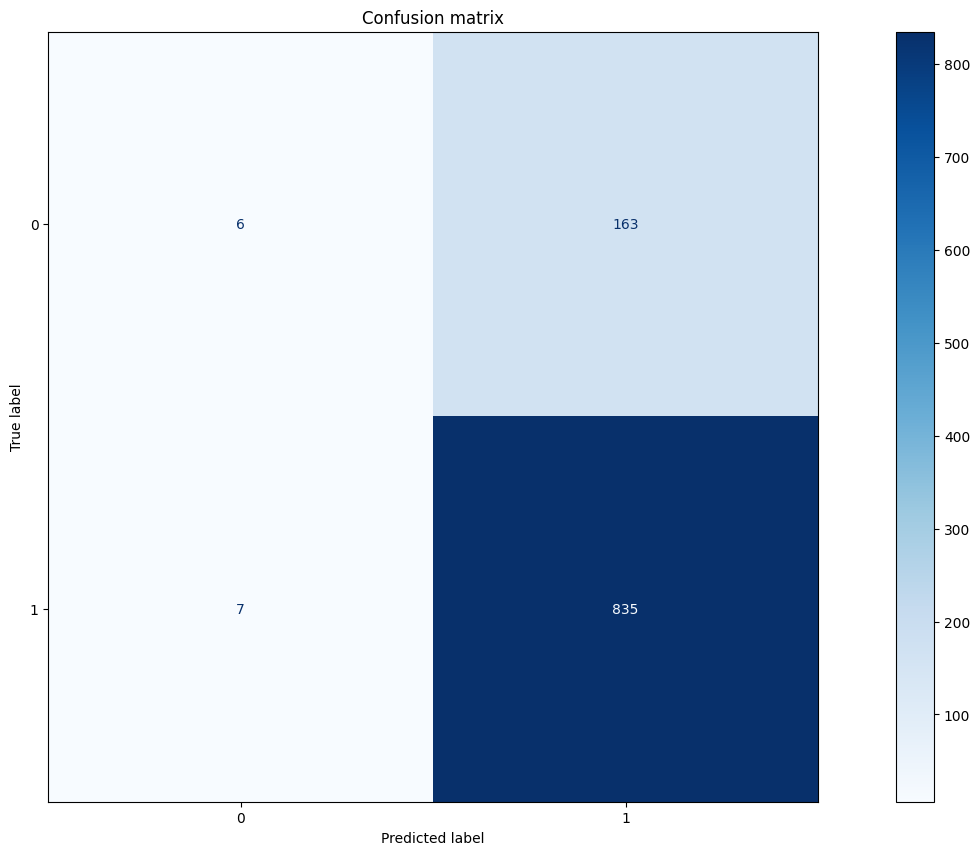

In [ ]:
# Display confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        xgb_clf,
        X_test,
        y_test,
        display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.set_title('Confusion matrix')
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.04      0.07       169
           1       0.84      0.99      0.91       842

    accuracy                           0.83      1011
   macro avg       0.65      0.51      0.49      1011
weighted avg       0.77      0.83      0.77      1011



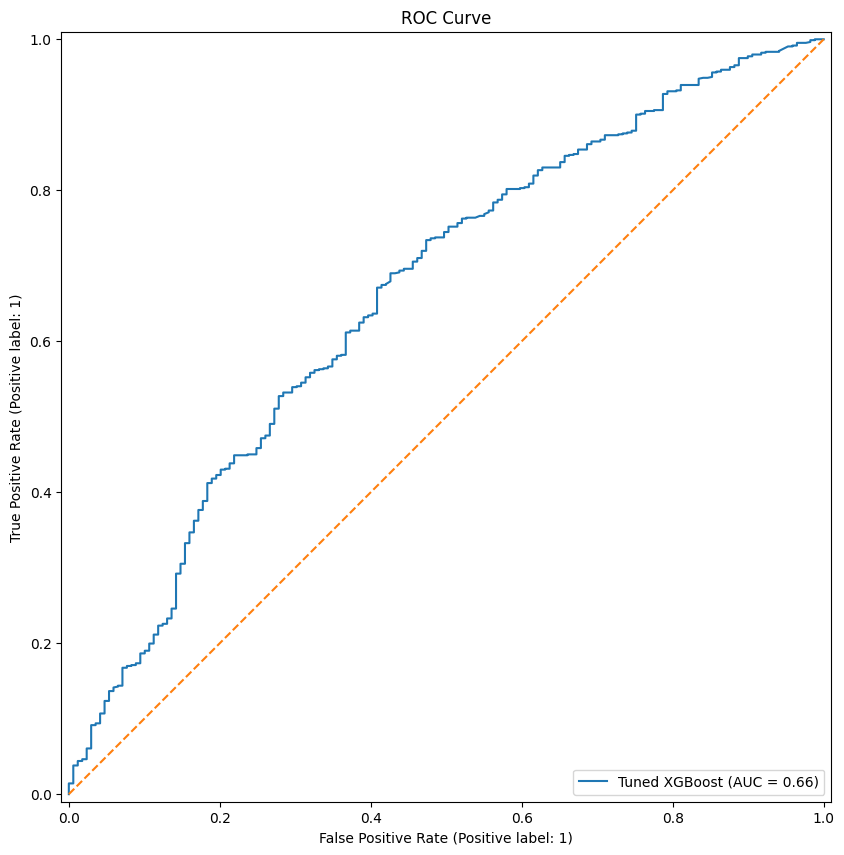

In [ ]:
# Display ROCCurve
disp_roc = RocCurveDisplay.from_estimator(
            xgb_clf,
            X_test,
            y_test,
            name='Tuned XGBoost')
disp_roc.ax_.set_title('ROC Curve')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()